In [1]:
import pandas as pd
import geopandas as gpd
from shapely.wkb import loads as wkb_loads
from shapely.geometry import Polygon
import folium
import matplotlib.pyplot as plt
from shapely import wkt
from geowrangler.validation import GeometryValidation
import rasterio
from rasterio.features import shapes


import os
from pathlib import Path

/home/abbymoreno/miniconda3/envs/lacuna-fund/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Generating Landcover features

The Landcover dataset we will be using is from [ESA WorldCover 2021](https://worldcover2021.esa.int/downloader). Extract the rasters for the lacuna cities before beginning this notebook.

### Input 

- ESA 2021 Raster
- Administrative boundaries

### Output

- Barangay-level dataframe with percent area covered for each landcover type

## Set input parameters

In [2]:
RASTERS_PATH = Path("../../../data/02-raw/esa/")

PROJ_CRS = "EPSG:4326"
LOCAL_CRS = "EPSG:3123"

In [3]:
# load raster filenames
esa_rasters = os.listdir(RASTERS_PATH)
print(esa_rasters)

['esa-mandaluyong.tif', 'esa-davao.tif', 'esa-navotas.tif', 'esa-zamboanga.tif', 'esa-muntinlupa.tif', 'esa-palayan.tif', 'esa-dagupan.tif', 'esa-mandaue.tif', 'esa-iloilo.tif', 'esa-cdo.tif', 'esa-legazpi.tif', 'esa-tacloban.tif']


## Convert rasters to polygons

In [4]:
def convert_tif_to_polygon(raster_file):
    with rasterio.open(raster_file) as src:
        raster_data = src.read(1)
        raster_meta = src.meta

    # convert the raster data into polygons
    polygons = []
    for shape, value in shapes(raster_data, transform=raster_meta["transform"]):
        polygons.append({"geometry": shape, "label": value})

    # # convert the polygons to a geopandas dataframe
    gdf = gpd.GeoDataFrame(polygons)
    gdf = gdf.dropna(subset=["label"])
    # extract coordinates from the 'geometry' column and convert them into Shapely geometries
    gdf["geometry"] = gdf["geometry"].apply(lambda x: Polygon(x["coordinates"][0]))

    gdf = gdf[["label", "geometry"]]

    return gdf

In [5]:
%%time

gdf_list = []
for tif_file in esa_rasters:
    gdf = convert_tif_to_polygon(RASTERS_PATH / tif_file)
    gdf = gdf.set_crs(PROJ_CRS)
    gdf_list.append(gdf)

CPU times: user 27.1 s, sys: 821 ms, total: 27.9 s
Wall time: 28.2 s


##  Check converted polygon data

In [6]:
gdf_list[3]

,label,geometry
0,30.0,"POLYGON ((122.10433 7.51375, 122.10433 7.51358..."
1,60.0,"POLYGON ((122.10442 7.51375, 122.10442 7.51367..."
2,10.0,"POLYGON ((122.10450 7.51375, 122.10450 7.51367..."
3,60.0,"POLYGON ((122.10475 7.51375, 122.10475 7.51367..."
4,60.0,"POLYGON ((122.10692 7.51375, 122.10692 7.51367..."
...,...,...
51131,95.0,"POLYGON ((122.06183 6.85850, 122.06183 6.85842..."
51132,30.0,"POLYGON ((122.06108 6.85842, 122.06108 6.85833..."
51133,30.0,"POLYGON ((122.06175 6.85850, 122.06183 6.85850..."
51134,30.0,"POLYGON ((122.06208 6.85842, 122.06208 6.85833..."


## Combine polygon data to one dataframe

In [7]:
# concatenate to one dataframe
gdf_big = pd.concat(gdf_list, ignore_index=True)
gdf_big.shape

(333122, 2)

In [8]:
gdf_big["label"].unique()

array([10., 60., 80., 40., 30., 50.,  0., 20., 90., 95.])

In [9]:
# dictionary of the labels definition https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200
# to map to column later
label_map = {
    10: "tree_cover",
    20: "shrubland",
    30: "grassland",
    40: "cropland",
    50: "builtup",
    60: "bare_sparse_vegetation",
    70: "snow_ice",
    80: "permanent_water_bodies",
    90: "herbaceous_wetland",
    95: "mangroves",
}

## Load AOI

In [10]:
aoi = gpd.read_file("../../../data/01-admin-bounds/target_admin_bounds.shp")
aoi.head(2)

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053..."
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039..."


In [11]:
# get barangay area
aoi = aoi.to_crs(LOCAL_CRS)
aoi["brgy_area"] = aoi["geometry"].area
aoi = aoi.to_crs(PROJ_CRS)
aoi = aoi[["ADM4_PCODE", "geometry", "brgy_area"]]

In [12]:
aoi.sort_values(by="brgy_area", ascending=False)

,ADM4_PCODE,geometry,brgy_area
411,PH112402901,"POLYGON ((125.27249 6.98510, 125.24862 7.00054...",2.279462e+08
117,PH112402073,"POLYGON ((125.30259 7.49590, 125.30288 7.49595...",1.738691e+08
204,PH097332901,"POLYGON ((122.03973 7.12940, 122.04060 7.13171...",1.414290e+08
704,PH112402121,"POLYGON ((125.44372 7.56527, 125.44716 7.56523...",1.177178e+08
209,PH097332097,"POLYGON ((122.31014 7.39317, 122.31320 7.38546...",1.130529e+08
...,...,...,...
356,PH083747037,"POLYGON ((125.00010 11.24615, 125.00106 11.245...",1.093631e+04
520,PH083747043,"POLYGON ((125.00294 11.24291, 125.00337 11.242...",8.614978e+03
190,PH083747057,"POLYGON ((125.00533 11.23942, 125.00533 11.239...",8.511064e+03
197,PH083747039,"POLYGON ((125.00352 11.24378, 125.00401 11.243...",7.510570e+03


## Computing landcover areas

In [13]:
%%time

aoi_copy = aoi.copy()
landcover = gdf_big.copy()

overlay = aoi_copy.overlay(landcover, how="intersection")
overlay["geometry"] = overlay["geometry"].to_crs(LOCAL_CRS)
overlay["area"] = overlay["geometry"].area

CPU times: user 19.5 s, sys: 145 ms, total: 19.6 s
Wall time: 19.6 s


In [14]:
# sorting of values, dropping duplicates and null values
overlay = overlay.sort_values(by="area", ascending=True)
overlay = overlay.drop_duplicates(subset=["ADM4_PCODE", "label", "area"], keep="last")
overlay = overlay.dropna(subset=["ADM4_PCODE"])
overlay = overlay.sort_values(by=["ADM4_PCODE", "label"], ascending=True)
overlay_merge = overlay.drop("geometry", axis=1)

In [15]:
# groupby label + aggregate total area for each label
label_area = (
    overlay_merge.groupby(["ADM4_PCODE", "label"])
    .agg(area=("area", "sum"))
    .reset_index()
)

# exclude the label 0 (refers to no nan)
label_area = label_area[label_area["label"] != 0]
label_area

,ADM4_PCODE,label,area
0,PH015518001,10.0,2.582837e+05
1,PH015518001,30.0,1.286791e+04
2,PH015518001,40.0,2.471744e+04
3,PH015518001,50.0,1.320202e+05
4,PH015518001,60.0,2.276612e+03
...,...,...,...
4404,PH137603009,30.0,5.857510e+05
4405,PH137603009,40.0,7.905049e+04
4406,PH137603009,50.0,6.925334e+06
4407,PH137603009,60.0,3.183145e+03


In [16]:
# drop overlay geometry from overlay gdf
result = pd.merge(left=aoi, right=label_area, on="ADM4_PCODE", how="left")

In [17]:
# replace numerical labels to their str counterparts
result = result.replace({"label": label_map})
result.head(3)

,ADM4_PCODE,geometry,brgy_area,label,area
0,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053...",1.020434e+06,tree_cover,6414.244420
1,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053...",1.020434e+06,grassland,2467.019287
2,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053...",1.020434e+06,cropland,82.233398


## Computing landcover percentages over a barangay

In [18]:
# pivot table to make each landcover type a column
pivot_labels = result.pivot(index="ADM4_PCODE", columns="label", values="area")
pivot_labels.head(3)

label,bare_sparse_vegetation,builtup,cropland,grassland,herbaceous_wetland,mangroves,permanent_water_bodies,shrubland,tree_cover
ADM4_PCODE,,,,,,,,,
PH015518001,2276.611726,132020.247855,24717.436194,12867.912920,11560.331402,NaN,275370.758662,NaN,258283.688939
PH015518002,780.068685,172224.969082,31337.232598,60137.005807,740.203180,NaN,73612.534745,NaN,269877.786386
PH015518003,283.353301,100768.990730,NaN,82.237679,NaN,NaN,7343.511966,NaN,6461.113968


In [19]:
# join again to main table
result = pd.merge(left=aoi, right=pivot_labels, on="ADM4_PCODE", how="left")

In [20]:
# landcover columns
lc_cols = [
    "bare_sparse_vegetation",
    "builtup",
    "cropland",
    "grassland",
    "herbaceous_wetland",
    "mangroves",
    "permanent_water_bodies",
    "shrubland",
    "tree_cover",
]

# get pct cover for each landcover type
for col in lc_cols:
    result[f"pct_area_{col}"] = 100 * (result[col] / result["brgy_area"])
result = result.fillna(0)
result = result.round(2)

In [21]:
# remove geometry and total area columns
drop_cols = ["geometry", "brgy_area"] + lc_cols
result = result.drop(columns=drop_cols)
result.insert(1, "date", "2021-01-01")
result.insert(2, "freq", "Y")
result.head(3)

,ADM4_PCODE,date,freq,pct_area_bare_sparse_vegetation,pct_area_builtup,pct_area_cropland,pct_area_grassland,pct_area_herbaceous_wetland,pct_area_mangroves,pct_area_permanent_water_bodies,pct_area_shrubland,pct_area_tree_cover
0,PH015518016,2021-01-01,Y,0.28,2.30,0.01,0.24,0.08,0.0,100.00,0.0,0.63
1,PH015518031,2021-01-01,Y,2.83,48.06,6.56,10.68,0.02,0.0,30.68,0.0,10.61
2,PH015518022,2021-01-01,Y,1.21,31.28,1.64,3.87,0.08,0.0,60.15,0.0,6.74


## Sample Land Cover Map

In [22]:
sample = overlay.copy()
sample = sample[sample["ADM4_PCODE"] == "PH112402901"]
sample = sample.to_crs(PROJ_CRS)
sample = sample.replace({"label": label_map})
sample

,ADM4_PCODE,brgy_area,label,geometry,area
104215,PH112402901,2.279462e+08,tree_cover,"POLYGON ((125.32175 6.97892, 125.32175 6.97892...",5.442351
102678,PH112402901,2.279462e+08,tree_cover,"POLYGON ((125.27775 7.19350, 125.27775 7.19342...",85.288153
102862,PH112402901,2.279462e+08,tree_cover,"POLYGON ((125.26950 7.18283, 125.26950 7.18275...",85.288307
102683,PH112402901,2.279462e+08,tree_cover,"POLYGON ((125.28375 7.19317, 125.28375 7.19308...",85.289540
102755,PH112402901,2.279462e+08,tree_cover,"POLYGON ((125.28583 7.18825, 125.28583 7.18817...",85.290910
...,...,...,...,...,...
100297,PH112402901,2.279462e+08,permanent_water_bodies,"POLYGON ((125.35893 7.18083, 125.35892 7.18083...",35.722335
103045,PH112402901,2.279462e+08,permanent_water_bodies,"POLYGON ((125.35558 7.16975, 125.35558 7.16967...",85.309876
103038,PH112402901,2.279462e+08,permanent_water_bodies,"POLYGON ((125.35567 7.16983, 125.35567 7.16975...",85.309879
104136,PH112402901,2.279462e+08,permanent_water_bodies,"POLYGON ((125.27925 6.98717, 125.27925 6.98708...",85.326125


/home/abbymoreno/miniconda3/envs/lacuna-fund/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


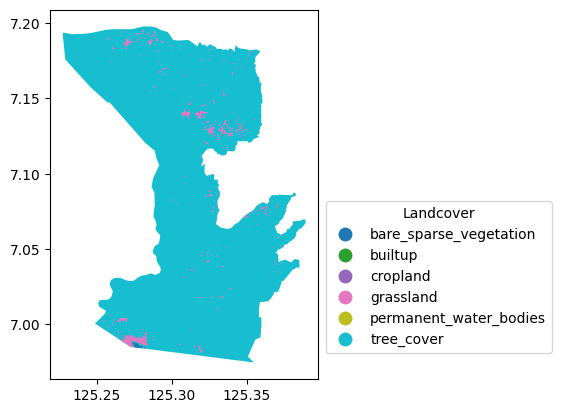

In [23]:
ax = sample.plot(column="label", legend=True, categorical=True)
legend = ax.get_legend()
legend.set_title("Landcover")
legend.set_bbox_to_anchor((1.9, 0.5))

for item in legend.get_texts():
    item.set_fontsize(10)

plt.show()

In [24]:
sample_df = result.copy()
sample_df = sample_df[sample_df["ADM4_PCODE"] == "PH112402901"]
sample_df

,ADM4_PCODE,date,freq,pct_area_bare_sparse_vegetation,pct_area_builtup,pct_area_cropland,pct_area_grassland,pct_area_herbaceous_wetland,pct_area_mangroves,pct_area_permanent_water_bodies,pct_area_shrubland,pct_area_tree_cover
411,PH112402901,2021-01-01,Y,0.08,0.0,0.0,2.06,0.0,0.0,0.0,0.0,100.06


## Save file

In [25]:
# save file
result_df = pd.DataFrame(result)
result.to_csv("../../../data/04-output/landcover_features_ESA_2021.csv", index=False)